### Packages installation

In [2]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint, solve_ivp
from lmfit import minimize, Parameters, report_fit, Minimizer
import matplotlib.pyplot as plt

#### Importation des données

In [3]:
file_path1 = (r'\Users\camil\Documents\IMT\2A\Stage_ingénierie\Notebook\Kon_16-04-2024_1.xlsx')
# Charger toutes les feuilles de calcul dans un dictionnaire de DataFrames
xls = pd.ExcelFile(file_path1)

# Afficher les noms des feuilles de calcul disponibles
print("Feuilles de calcul disponibles :", xls.sheet_names)

# Lire une feuille spécifique 
df = pd.read_excel(file_path1, sheet_name='Feuille 2')

Feuilles de calcul disponibles : ['Feuille 1', 'Feuille 2', 'Feuille 3']


In [4]:
t = df['Time points (min)'].values
data = df['Luminescence ligne 1'].values
data2 = df['Luminescence ligne 2'].values
data3 = df['Luminescence ligne 3'].values
data4 = df['Luminescence ligne 4'].values
data5 = df['Luminescence ligne 5'].values
data6 = df['Luminescence ligne 6'].values
data7 = df['Luminescence ligne 7'].values
data8 = df['Luminescence ligne 8'].values

In [6]:
file_path2 = (r'\Users\camil\Documents\IMT\2A\Stage_ingénierie\Notebook\Kon_18-04-2024.xlsx')
# Charger toutes les feuilles de calcul dans un dictionnaire de DataFrames
xls_1 = pd.ExcelFile(file_path2)

# Afficher les noms des feuilles de calcul disponibles
print("Feuilles de calcul disponibles :", xls_1.sheet_names)

# Lire une feuille spécifique 
df_1 = pd.read_excel(file_path2, sheet_name='Feuille 1')

Feuilles de calcul disponibles : ['Feuille 1', 'Feuille 2', 'Feuille 3']


In [7]:
t = df_1['Time points (min)'].values
dt = df_1['Luminescence ligne 1'].values
dt2 = df_1['Luminescence ligne 2'].values
dt3 = df_1['Luminescence ligne 3'].values
dt4 = df_1['Luminescence ligne 4'].values
dt5 = df_1['Luminescence ligne 5'].values
dt6 = df_1['Luminescence ligne 6'].values
dt7 = df['Luminescence ligne 7'].values
dt8 = df['Luminescence ligne 8'].values

#### Normalisation des données

In [8]:
data_norm = (dt - np.min(dt)) / (np.max(dt) - np.min(dt))
data_norm2 = (dt2 - np.min(dt2)) / (np.max(dt2) - np.min(dt2))
data_norm3 = (dt3 - np.min(dt3)) / (np.max(dt3) - np.min(dt3))
data_norm4 = (dt4 - np.min(dt4)) / (np.max(dt4) - np.min(dt4))
data_norm5 = (dt5 - np.min(dt5)) / (np.max(dt5) - np.min(dt5))
data_norm6 = (dt6 - np.min(dt6)) / (np.max(dt6) - np.min(dt6))
data_norm7 = (dt7 - np.min(dt7)) / (np.max(dt7) - np.min(dt7))
data_norm8 = (dt8 - np.min(dt8)) / (np.max(dt8) - np.min(dt8))

#### Conservation de la masse

In [9]:
def check_mass_conservation(A, B, C, A0, B0, rtol=1e-6):
    initial_mass = A0 + B0
    current_mass = A + B + C
    if not np.isclose(initial_mass, current_mass, rtol=rtol):
        raise ValueError(f"Mass not conserved. Difference: {initial_mass - current_mass}")

##### Système d'équations différentielles à résoudre

In [10]:
def model(t, y, params):
    A0 = params['A0'].value
    B0 = params['B0'].value
    kon = params['kon'].value
    koff = params['koff'].value

    print(f"y = {y}")
    # A concentration du en anti corps, B concentration en anti gene et C concentration du complexe
    A,B,C = y

    check_mass_conservation(A, B, C, A0, B0)

    # Cinétique de liaison des AC et AG
    dAdt = -kon * A * B + koff * C
    dBdt = -kon * A * B + koff * C
    dCdt = kon * A * B - koff * C 

    return [dAdt, dBdt, dCdt]


##### Modèle résolution EDO

In [11]:
def solve_model(t, params):
    A0 = params['A0'].value
    B0 = params['B0'].value
    y0 = [A0, B0, 0]

    sol = solve_ivp(lambda t, y: model(t, y, params), [t[0], t[-1]], y0, 
                    t_eval=t, method='Radau', rtol=1e-9, atol=1e-9)
    
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")
    
    return sol.y.T

In [58]:
'''def ru_model(t, params):
    A0 = params['A0'].value
    B0 = params['B0'].value
    alpha = params['alpha'].value
    beta = params['beta'].value
    y0 = [A0, B0, 0]

    sol = solve_ivp(lambda t, y: model(t, y, params), [t[0], t[-1]], y0, t_eval=t, method='BDF', rtol=1e-6, atol=1e-6)
    # Transposée
    solution = sol.y.T
    
    if not sol.success:
        print(f"solve_ivp failed: {sol.message}")
        return np.full((len(t), 3), np.nan)
    
    print("La solution du modèle est : \n", solution[:,2])

    return solution'''


'def ru_model(t, params):\n    A0 = params[\'A0\'].value\n    B0 = params[\'B0\'].value\n    alpha = params[\'alpha\'].value\n    beta = params[\'beta\'].value\n    y0 = [A0, B0, 0]\n\n    sol = solve_ivp(lambda t, y: model(t, y, params), [t[0], t[-1]], y0, t_eval=t, method=\'BDF\', rtol=1e-6, atol=1e-6)\n    # Transposée\n    solution = sol.y.T\n    \n    if not sol.success:\n        print(f"solve_ivp failed: {sol.message}")\n        return np.full((len(t), 3), np.nan)\n    \n    print("La solution du modèle est : \n", solution[:,2])\n\n    return solution'

##### Résidu

In [12]:
def residu(params, t, data):
    try:
        model_values = solve_model(t, params)[:, 2]  # On prend la concentration du complexe C
        return (model_values - data_norm) # On compare avec les données normalisées
    except Exception as e:
        print(f"Error in residual function: {str(e)}")
        return np.full_like(data_norm, np.inf)

In [60]:
'''def residu(params, t, data):
    model_values = ru_model(t, params)[:,2]

    if np.isnan(model_values).any():
        print("NaN detected in model values")
        return np.full_like(data, np.inf) 
    
    if model_values.shape != data.shape:
        print(f"Shape mismatch: model_values shape is {model_values.shape}, data shape is {data.shape}")
        return np.full_like(data, np.inf)
        
    return (model_values - data)'''



'def residu(params, t, data):\n    model_values = ru_model(t, params)[:,2]\n\n    if np.isnan(model_values).any():\n        print("NaN detected in model values")\n        return np.full_like(data, np.inf) \n    \n    if model_values.shape != data.shape:\n        print(f"Shape mismatch: model_values shape is {model_values.shape}, data shape is {data.shape}")\n        return np.full_like(data, np.inf)\n        \n    return (model_values - data)'

##### Paramètres initiaux

In [13]:
params = Parameters()
params.add('alpha', value=1e3, min=0, max=1e5)
params.add('beta', value=1, min=0, max=1e2)
params.add('kon', value=1e5, min=1e3, max=1e7, vary= True)  
params.add('koff', value=1e-2, min=1e-4, max=1, vary= True)  
params.add('A0', value=2e-5, min=1e-9, max=1e-4, vary= True)  
params.add('B0', value=3e-6, min=1e-9, max=1e-4, vary= True)  

In [14]:
# Optimisation
try:
    result = minimize(residu, params, args=(t, data_norm), method='leastsq', max_nfev=1000)
    print(report_fit(result))
    
    if result.success:
        print("Optimisation réussie.")
        fitted_values = solve_model(t, result.params)[:, 2]
        
        # Dénormaliser les valeurs ajustées
        fitted_values = fitted_values * (np.max(dt) - np.min(dt)) + np.min(dt)
        
        # Ici, vous pouvez ajouter du code pour tracer les résultats
        # import matplotlib.pyplot as plt
        plt.plot(t, dt, 'o', label='Données')
        plt.plot(t, fitted_values, '-', label='Modèle ajusté')
        plt.legend()
        plt.show()
    else:
        print("L'optimisation a échoué.")
except Exception as e:
    print(f"Une erreur s'est produite pendant l'optimisation : {str(e)}")

y = [2.e-05 3.e-06 0.e+00]
y = [ 2.01167605e-05  3.11676047e-06 -1.16760470e-07]
Error in residual function: Mass not conserved. Difference: -1.1676046955145651e-07
Une erreur s'est produite pendant l'optimisation : NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.


In [63]:
'''# Exécution de l'optimisation
minimizer = Minimizer(residu, params, fcn_args=(t, data3))
result = minimizer.minimize(method='trust_exact')

# Vérification du succès de l'optimisation
print(f"Optimization success: {result.success}")
if result.success:
    print("Optimization successful.")
else:
    print("Optimization failed.")

print(report_fit(result))
fitted_ru = ru_model(t, result.params)'''


'# Exécution de l\'optimisation\nminimizer = Minimizer(residu, params, fcn_args=(t, data3))\nresult = minimizer.minimize(method=\'trust_exact\')\n\n# Vérification du succès de l\'optimisation\nprint(f"Optimization success: {result.success}")\nif result.success:\n    print("Optimization successful.")\nelse:\n    print("Optimization failed.")\n\nprint(report_fit(result))\nfitted_ru = ru_model(t, result.params)'

In [71]:
def analyze_sensitivity(params, t, data, vary_percent):
    # Erreur quadratique 
    base_model =ru_model(t, params)[:,2]
    base_residual = np.sum((base_model - data)**2)
    # Création d'un dictionnaire pour stocker les valeurs de sensibilité pour chaque variable
    sensitivities = {}
    
    for name in params:
        original_value = params[name].value
        # Modifie la valeur du paramètre en l'augmentant de vary_percent pourcent par rapport à sa valeur initiale.
        params[name].set(value=original_value * (1 + vary_percent/100))
        # Mise à jour du nouveau résidu
        new_model = ru_model(t, params)[:, 2]  # Utilise seulement la troisième colonne
        new_residual = np.sum((new_model - data)**2)
        # Calcul de la sensibilité relative
        sensitivity = (new_residual - base_residual) / base_residual
        # on affecte cette valeur à une variable
        sensitivities[name] = sensitivity
        params[name].set(value=original_value)  # Reset to original value
        
    return sensitivities

# paramètre de variation de variable
vary_percent= 10
sensitivities = analyze_sensitivity(result.params, t, data3, vary_percent)


plt.figure(figsize=(10, 6))
plt.bar(sensitivities.keys(), sensitivities.values())
plt.title('Analyse de sensibilité')
plt.xlabel('Paramètres')
plt.ylabel('Sensibilité relative')
plt.show()

y = [2.e-05 3.e-06 0.e+00]
y = [ 2.01167605e-05  3.11676047e-06 -1.16760470e-07]


ValueError: Mass not conserved. Difference: -1.1676046955145651e-07

##### Plots

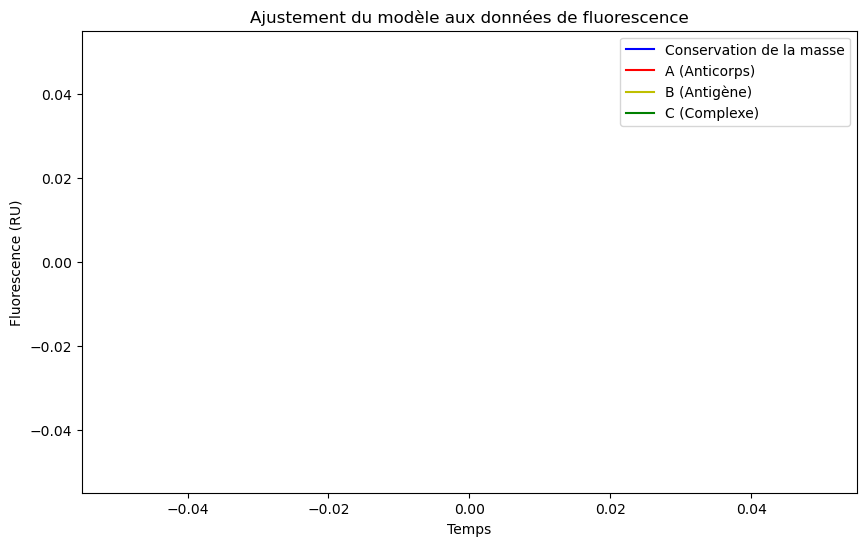

In [72]:
total_mass = fitted_ru[:, 0] + fitted_ru[:, 1] + fitted_ru[:, 2]

plt.figure(figsize=(10,6))
#plt.plot(t,data2, 'o', label='Données expérimentales de fluorescence(RU)')
plt.plot(t, total_mass, 'b', label ='Conservation de la masse')
plt.plot(t, fitted_ru[:, 0], 'r', label='A (Anticorps)')
plt.plot(t, fitted_ru[:, 1], 'y', label='B (Antigène)')
plt.plot(t, fitted_ru[:, 2], 'g', label='C (Complexe)')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Fluorescence (RU)')
plt.title('Ajustement du modèle aux données de fluorescence')
plt.show()

In [73]:
for name, param in result.params.items():
    value = param.value

    print(f"{name}: {value:.4e}")
    

kon: 1.0000e+05
koff: 1.0000e-02
A0: 2.0000e-05
B0: 3.0000e-06
